# Problem 1

## Importing libraries

In [0]:
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Comment to get non-deterministic results
np.random.seed(2)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Problem 1.

**Building the Model**

1.    Forward and backward propagation for single exemples (forward and backward functions)
    and for matrices (forward_mbatch and backward_mbatch functions)
    
2.    This implemetation does not use any deep learning frameworks with automatic differentiation

3. We trained the model using the probability loss (cross entropy) as training criterion. See the loss function.

In [0]:
#Several functions in this class implementation are inspired from the NN implemented in cours IFT6093

class NN(object):
    
    '''
    Arguments:
        input_dim: The input dimension
        output_dim: The output dimension
        hidden_dims: (h1 dimension, h2 dimension)
        n_hidden: number of hidden layers
        initialization: type of weigth initialization (zeros, normal or glorot)
    
    '''
    
    def __init__(self, input_dim, output_dim,hidden_dims=(1024,2048),n_hidden=2, initialization='zeros', mode=',train',
                 datapath=None,model_path=None):
        
        self.indim = input_dim
        self.hd1 = hidden_dims[0] 
        self.hd2 = hidden_dims[1]
        self.n_hidden = n_hidden
        self.outd = output_dim
        self.W1 = np.zeros(shape=(hidden_dims[0], input_dim))
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.zeros(shape=(hidden_dims[1], hidden_dims[0]))
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.zeros(shape=(output_dim, hidden_dims[1]))
        self.b3 = np.zeros(output_dim)
        
        
        if initialization=='normal':
            self.initialize_weights_normal()
            
        if initialization=='glorot':
            self.initialize_weights_glorot()
           
        self.parameters = [self.W3, self.b3, self.W2, self.b2, self.W1, self.b1]
        
        
    def initialize_weights_normal(self):
        
        self.W1 = np.random.normal(size=(self.hd1, self.indim))
        self.W2 = np.random.normal(size=(self.hd2, self.hd1))
        self.W3 = np.random.normal(size=(self.outd, self.hd2))
        return self
    
    
    
    def initialize_weights_glorot(self):
        
        dl1 = np.sqrt(6/(self.indim + self.hd1))
        dl2 = np.sqrt(6/(self.hd1 + self.hd2))
        dl3 = np.sqrt(6/(self.hd2 + self.outd))
        self.W1 = np.random.uniform(low=(-dl1), high=dl1, size=(self.hd1, self.indim))
        self.W2 = np.random.uniform(low=(-dl2), high=dl2, size=(self.hd2, self.hd1))
        self.W3 = np.random.uniform(low=(-dl3), high=dl3, size=(self.outd, self.hd2))
        return self
        
        
    #Method from NN implemented in cours IFT6093
    def activation (self,input):
        
        return (input > 0) * input  
    
    #line 85

    
    # forward for single exemple
    def forward(self,x):
                
        a1 = np.dot (self.W1, x) + self.b1 
        h1 = self.activation (a1)
        a2 = np.dot (self.W2, h1) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (self.W3, h2) + self.b3
        os = self.softmax (oa, axis=0)
        
        return a1, h1, a2, h2, oa, os
    
    def setZero(self, a ):
        a[ np.abs( a ) <= zero ] = zero
        return a

    #Loss function using probability loss (cross entropie)
    def loss (self, y, os):
        return (self.setZero(y) * (-np.log(self.setZero(os)))).sum()
    
    #ans softmax methods from NN implemented in cours IFT6093
    def softmax (self,x,axis=1):
        shiftx = x - np.max (x, axis=axis, keepdims=True)
        exps = np.exp (shiftx)
        y = exps / exps.sum (axis=axis, keepdims=True)
        return y


    #Backward for single exemple
    def backward(self, x, y, a1, h1, a2, h2, oa, os, weight_decay=0, cache=None):
        
        grad_oa = os - y
        grad_W3 = np.outer (grad_oa, h2) + weight_decay * self.W3
        grad_b3 = grad_oa
        grad_h2 = np.dot (self.W3.T, grad_oa)
        grad_a2 = (a2 > 0) * grad_h2
        grad_W2 = np.outer (grad_a2, h1) + weight_decay * self.W2
        grad_b2 = grad_a2
        grad_h1 = np.dot (self.W2.T, grad_a2)
        grad_a1 = (a1 > 0) * grad_h1
        grad_W1 = np.outer (grad_a1, x) + weight_decay * self.W1
        grad_b1 = grad_a1
        grads=[grad_W3, grad_b3, grad_W2, grad_b2, grad_W1, grad_b1]
   
        return grads



    def update(self, grads, learning_rate):
        for p, grad in zip(self.parameters, grads):
            p -= learning_rate * grad
        
    #line 201   

    #Sthocastic gradient descent method (litteral)
    def train_SGD(self, x, y_onehot, n, learning_rate=1e-1, weight_decay=0):
                
        y = y_onehot
        losses = 0
        if (n==1):
            a1, h1, a2, h2, oa, os = self.forward(x)
            grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
            self.update(grads, learning_rate)
            loss = self.loss(y, os)
            losses += loss  
            average_loss = losses / x.shape[0]
        else:    
            for j in range(x.shape[0]):
                a1, h1, a2, h2, oa, os = self.forward(x[j])
                grads = self.backward(x[j], y[j], a1, h1, a2, h2, oa, os)
                self.update(grads, learning_rate)
                loss = self.loss(y[j], os)
                losses += loss     
            average_loss = losses / x.shape[0]
                
        return average_loss
    
    
    def prediction_SGD (self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            predictions[i] = os.argmax()
                
        return predictions
                
    
    def accuracy_SGD (self, prediction, y):
        accuracies=0
        for i in range (y.shape[0]):
            accuracies+=(prediction[i]==y[i])
            
        return accuracies / y.shape[0]
    
    
    def test_SGD(self, x, y_onehot, y):
        pred=np.zeros(y.shape[0])
        avg_loss=0
        for i in range (x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            loss=self.loss (y_onehot[i], os)
            avg_loss+=loss
            pred[i]=os.argmax()
            
        accuracy=self.accuracy_SGD(pred, y)    
        return avg_loss / x.shape[0] , accuracy
    
   
    #Sthocastic Gradien Descent method with minibatch (using matrices)
    def forward_mbatch(self, x):
                
        a1 = np.dot ( x, self.W1.T) + self.b1
        h1 = self.activation (a1)
        a2 = np.dot (h1, self.W2.T) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (h2, self.W3.T) + self.b3
        os = self.softmax (oa, axis=1)
                
        return a1, h1, a2, h2, oa, os
    
    #line 303
        
    def backward_mbatch(self, x, y, a1, h1, a2, h2, oa, os, batch_n, weight_decay=0):
                
        batch_n = x.shape[0]
        bgrad_oa = os - y
        bgrad_W3 = np.dot (bgrad_oa.T, h2) / batch_n  + weight_decay * self.W3
        bgrad_b3 = bgrad_oa.mean(axis=0)
        bgrad_h2 = np.dot (bgrad_oa, self.W3)
        bgrad_a2 = (a2 > 0) * bgrad_h2
        bgrad_W2 = np.dot (bgrad_a2.T, h1) / batch_n  + weight_decay * self.W2
        bgrad_b2 = bgrad_a2.mean(axis=0)
        bgrad_h1 = np.dot (bgrad_a2, self.W2)
        bgrad_a1 = (a1 > 0) * bgrad_h1
        bgrad_W1 = np.dot (bgrad_a1.T, x) / batch_n  + weight_decay * self.W1
        bgrad_b1 = bgrad_a1.mean(axis=0)
        bgrads=[bgrad_W3, bgrad_b3, bgrad_W2, bgrad_b2, bgrad_W1, bgrad_b1]
   
        return bgrads

    #line 360

    #Method taken fron homwork 3 in cours IFT6093
    def loss_mbatch(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)     
        
    
    #training with minibatch gradient decent
    def train_mbatch(self, x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0):
                
        average_loss=0
        for i in range (0, x.shape[0], mb_size):
            xi = x[i:(i+mb_size)]
            yi = y_onehot[i:(i+mb_size)]
        
            #losses = 0
            a1, h1, a2, h2, oa, os = self.forward_mbatch(xi)
            grads = self.backward_mbatch (xi, yi,a1, h1, a2, h2,oa, os, mb_size)
            self.update(grads, learning_rate)
            average_loss = self.loss_mbatch(os, yi) 
                          
        return average_loss
    
    
    #line 385
    
    def prediction_mbatch (self, x):
        _, _, _, _, _, os = self.forward_mbatch(x)
        return os.argmax(axis=1)
    

    def accuracy_mbatch (self, prediction, y):
        accuracy = np.zeros(y.shape[0])
        accuracy = prediction == y
        return accuracy.mean(axis=0)
    

    def test_mbatch(self, x, y_onehot, y):
        _, _, _, _, _, os = self.forward_mbatch(x)
        loss = self.loss_mbatch (os, y_onehot)
        accuracy=self.accuracy_mbatch (os.argmax(axis=1), y)
        return loss, accuracy
    
    
    def finite_difference():
        
        pass


## Function onehot

In [0]:
#function taken from IFT6093 cours
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

## Data loader

Getting data from the mnist.pkl.gz file

In [0]:
import gzip, pickle
with gzip.open('gdrive/My Drive/mnist.pkl.gz','rb') as ff :
    u = pickle._Unpickler( ff )
    u.encoding = 'latin1'
    train, val, test = u.load()
    
X_train, y_train = train
X_valid, y_valid = val
X_test, y_test = test

Processing data set

In [0]:

# Data normalization

X_train= X_train / 255
X_valid= X_valid/ 255
X_test = X_test / 255

# train_data randomization
indices_t = list(range(len(X_train)))
shuffle(indices_t)
X_train, y_train=  X_train[indices_t[:]], y_train[indices_t[:]]

# validation_data randomization
indices_v = list(range(len(X_valid)))
shuffle(indices_v)
X_valid, y_valid = X_train[indices_v[:]], y_train[indices_v[:]]

#geting onehot(y)
digit_y_train_onehot= onehot (y_train, 10)
digit_y_valid_onehot= onehot (y_valid, 10)
digit_y_test_onehot= onehot (y_test, 10)

X_train = np.array (X_train)
y_train = np.array (y_train)
X_valid= np.array (X_valid)
y_valid= np.array (y_valid)
X_test = np.array (X_test)
y_test = np.array (y_test)


print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_valid shape = ', X_valid.shape)
print('y_valid shape = ', y_valid.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (50000, 784)
y_train shape =  (50000,)
X_valid shape =  (10000, 784)
y_valid shape =  (10000,)
X_test shape =  (10000, 784)
y_test shape =  (10000,)


Learning curves function

In [0]:
#This function returns the learning curves grafics

def learning_curves(losses_train, accs_train, losses_valid, accs_valid,
                    losses_test, accs_test, h1, h2):
  
 
  plt.figure(figsize=(12, 4))
  axis = plt.subplot(1, 2, 1)
  axis.plot(range(1, epochs+1), losses_train, label='train')
  axis.plot(range(1, epochs+1), losses_valid, label='valid')
  axis.plot(range(1, epochs+1), losses_test, label='test')
  
  axis.legend()
  axis.set_ylabel('Loss')
  axis.set_xlabel('Epochs')
  plt.title(('h_1 = ', h1, 'h_2 =', h2))
  
  
  axis = plt.subplot(1, 2, 2)
  axis.plot(range(1, epochs+1), accs_train, label='train')
  axis.plot(range(1, epochs+1), accs_valid, label='valid')
  axis.plot(range(1, epochs+1), accs_test, label='test')
  
  
  axis.legend()
  axis.set_ylabel('Accuracy')
  axis.set_xlabel('Epochs')
  plt.title(('h_1 = ', h1, 'h_2 =', h2))
  
  #axis.set_title('%d hidden units' % (h1,', ', h2))
  
  
  
  
  

**Building the model .**

3. Training  the MLP using the probability loss (
cross entropy
) as training criterion.  

.
In this part we use sthocastic gradient descent to optimize the number of hidden unites to be between 0.5 M and 1M

Validation accuracy for h1=  500 h2 = 200 :  0.8093
Validation accuracy for h1=  500 h2 = 300 :  0.8188
Validation accuracy for h1=  800 h2 = 200 :  0.8476
Validation accuracy for h1=  800 h2 = 300 :  0.6502


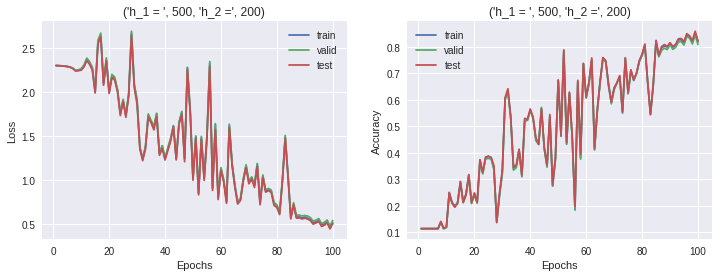

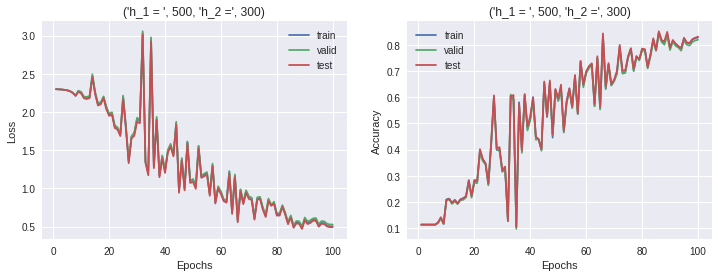

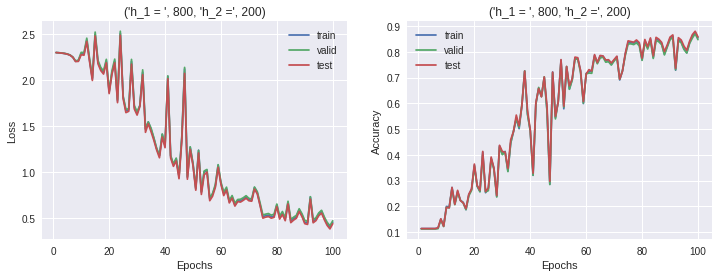

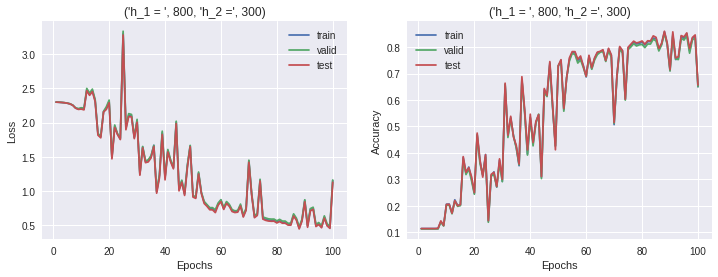

In [0]:
#3. Training the model with sthocastic gradient descent

zero=10**-15


for i, h1 in enumerate([500, 800]):
  
  for j, h2 in enumerate ([200, 300]):
  
  
    NN_SGD = NN(784, 10, hidden_dims=(h1, h2), initialization='glorot')
    
    # Model training 
    losses_train, accs_train = [], []
    losses_valid, accs_valid = [], []
    losses_test, accs_test = [], []

    epochs=100

    for epoch in range (epochs):
  
      loss = NN_SGD.train_mbatch(X_train, digit_y_train_onehot, mb_size=100)

    #Test in validation and test set: test_mbatch(x_t, y_t_o, y_t)
    
      loss_train, acc_train = NN_SGD.test_mbatch(X_train, digit_y_train_onehot, y_train)
      loss_valid, acc_valid = NN_SGD.test_mbatch(X_valid, digit_y_valid_onehot, y_valid) 
      
    
      losses_train.append(loss_train) 
      accs_train.append(acc_train)
      losses_valid.append(loss_valid)
      accs_valid.append(acc_valid)
      
    
    learning_curves(losses_train, accs_train, losses_valid, accs_valid,
                    losses_test, accs_test, h1, h2)

    print ('Validation accuracy for h1= ', h1, 'h2 =', h2, ': ', acc_valid)

The best combination was h1=800, h2=200 with accuracy 84 %

## Initialization

In [0]:
# Function to plot loss under different initialization weight types

def graf_normalization (epochs, zeros_losses, normal_losses, glorot_losses):
  fig = plt.figure()
  plt.plot(range(epochs),  zeros_losses, label='zeros')
  plt.plot(range(epochs), normal_losses, label='normal')
  plt.plot(range(epochs), glorot_losses, label='glorot')

  plt.set_ylabel('Loss')
  plt.set_xlabel('Epochs')
  plt.title("Initialization")

  plt.legend()
  plt.show()

Training with initialization: zeros, normal, glorot. Epoch 10

In [0]:
#1. Weigths initialization data from dataloader

print('Weigths initialization')

# Set timer
import time
start_time = time.time()

#training 10 epochs for each initialization type
epochs=10

zeros_losses=[]
normal_losses=[]
glorot_losses=[]
weigths=['zeros', 'normal', 'glorot']

for i, init in enumerate(weigths, 0):
    
    NN_digits= NN(784, 10, hidden_dims=(500,300), initialization=init)

    for epoch in range (epochs): 
    
        loss=NN_digits.train_mbatch(X_train, digit_y_train_onehot, mb_size=100)
        if (init=='zeros'):
            zeros_losses.append(loss)
        if (init == 'normal'):
            normal_losses.append(loss)
        if (init == 'glorot'):
            glorot_losses.append(loss)
            
time_mb = time.time() - start_time
print('Time with minibatch gradient decent implementation: %f seconds\n' % time_mb)





Weigths initialization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


Time with minibatch gradient decent implementation: 302.416088 seconds



In [0]:
# Make graphic for different weigths initialization

graf_normalization (epochs, zeros_losses, normal_losses, glorot_losses)

## Parameter search

Hyperparameter search function

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Display differents graphs using different hyperparameters saved in arrays.
# Input variables are arrays with the same lenght, with the values to graph

def show_graphs(minibatch_arr,epoch_arr,learningrate_arr,loss_arr):
# define a list of markevery cases to plot
    cases=[]
    x_values=[]
    y_values=[]
    for i in range(len(minibatch_arr)):
        cases.append([minibatch_arr[i],epoch_arr[i],learningrate_arr[i]])
        # define the data for cartesian plots
        x_values.append(range(epoch_arr[i]))
        y_values.append(loss_arr[i])
    # define the figure size and grid layout properties
    figsize = (10, 6)
    cols = 2
    gs = gridspec.GridSpec(len(cases) // cols + 1, cols)
    gs.update(hspace=0.4)
    
    fig1 = plt.figure(num=1, figsize=figsize)
    ax = []
    for i, case in enumerate(cases):
        row = (i // cols)
        col = i % cols
        ax.append(fig1.add_subplot(gs[row, col]))
        ax[-1].set_title('Minibatch=%s, Epoch=%s, Learning=%s' % (str(case[0]),str(case[1]),str(case[2])))
        ax[-1].plot(x_values[i], y_values[i], 'o', ls='-', ms=4, markevery=1)

In [0]:
# Train the model using different hyperparameters, like mini-batch size, learning rate and epochs number
# x_ds is the dataset to train, y_ds is the target dataset.

# function to test different hyperparameters
# x_ds and y_ds must be the training set

def hyperparameter_search(model, x_t, y_t, y_t_o, x_v, y_v, y_v_o, epochs, minibatch, learningrate,
                          verbose=False):
    
    # NN model
    # NN_mbatch_1 = NN(784, 10, hidden_dims=(500,300), initialization='glorot')
    
    # Model training 
    losses_train, accs_train = [], []
    losses_valid, accs_valid = [], []
    losses_test, preds_test = [], []
            
    for epoch in range (epochs): 
        
        # Always train in training set       
        loss_mbatch_1 = model.train_mbatch(x_t, y_t_o, mb_size=minibatch,
                                                 learning_rate=learningrate)
        if verbose:
            print('epoch ', epoch, ' loss ', loss_mbatch_1)
            
        #Test in validation set to adjust Hyperparameters        
        loss_train, acc_train = model.test_mbatch(x_t, y_t_o, y_t)
        loss_valid, acc_valid = model.test_mbatch(x_v, y_v_o, y_v)        
        
        
        losses_train.append(loss_train) 
        accs_train.append(acc_train)
        losses_valid.append(loss_valid)
        accs_valid.append(acc_valid)
        
    print('epoch ', epoch, ' loss ', loss_mbatch_1)
    
    #Only at the end, test in test set }
    
    return losses_train, acc_train, losses_valid, acc_valid, model

In [0]:
# testing for different h1 size

for i, h1 in enumerate([500, 600, 800, 1000]):
    print(h1)
    
    NN_mbatch_1 = NN(784, 10, hidden_dims=(h1,300), initialization='glorot')
    
    losses_train, acc_train, losses_valid, acc_valid, NN_mbatch_1 = hyperparameter_search(
        NN_mbatch_1, X_train, y_train, digit_y_train_onehot, X_valid, y_valid, digit_y_valid_onehot, 
        10, 100, 1e-1, verbose=False)
    
 


500
epoch  0  loss  0.14581453092038102
epoch  1  loss  0.08653862662573525
epoch  2  loss  0.05584058661953494
epoch  3  loss  0.03977169112867238
epoch  4  loss  0.029163141280530488
epoch  5  loss  0.022867748552135483
epoch  6  loss  0.018304303721175932
epoch  7  loss  0.015072465969688517
epoch  8  loss  0.012517681531048827
epoch  9  loss  0.01040159495356941
epoch  9  loss  0.01040159495356941
600
epoch  0  loss  0.14400304299939368
epoch  1  loss  0.08327159855685291
epoch  2  loss  0.05222551711269508
epoch  3  loss  0.036253690260122685
epoch  4  loss  0.027346689746163687
epoch  5  loss  0.022180972603945564
epoch  6  loss  0.018563148203478017
epoch  7  loss  0.015449373732080315
epoch  8  loss  0.013088962738955691
epoch  9  loss  0.010971804726865384
epoch  9  loss  0.010971804726865384
800
epoch  0  loss  0.1239439884161044
epoch  1  loss  0.06904779049486472
epoch  2  loss  0.04559550672097166
epoch  3  loss  0.03323956798016456
epoch  4  loss  0.026215202329884675
epo

## Finite difference

In [0]:
#Approximation of the gradient of the loos at the end of training, with respect to W3 
# (the second layer weigths) with to the first p = min(10;m) elements of W3.


#function to calculate the finite difference for  

def loop_finite_diff(self, x, y, epsilon=1e-5):
        a1, h1, a2, h2, oa, os = self.forward(x)
        grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
        loss = self.loss(y, os)
        
        grads_finite_diff = []
        
        for p in self.parameters[0]:
            grad_fdiff = np.zeros(shape=p.shape)
            for i, v in np.ndenumerate(p):
                p[i] += epsilon
                _, _, _, _, _, os = self.forward(x)
                loss_diff = self.loss(os, y)
                grad_fdiff[index] = (loss_diff - loss) / epsilon
                p[index] -= epsilon
            grads_finite_diff.append(grad_fdiff)
        return gradients_finite_diff

In [0]:
#1. epsilon = 1 / N

#Use at least 5 values of N from the set {k10**i : i E {0; : : : ; 5g} k E {1, 5}}
epsilon=[]
N = []
for exp in range (1, 6, 2):
    a= 10**exp
    N.append(a)
for exp in range (1, 5, 2):
    b= 5*10**exp
    N.append(b)
for i in range (5):
    epsilon.append(1/N[i])

print (N)
print (epsilon)




[10, 1000, 100000, 50, 5000]
[0.1, 0.001, 1e-05, 0.02, 0.0002]
